In [2]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 글꼴 경로 설정 (예: Malgun Gothic)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 경우
font_prop = fm.FontProperties(fname=font_path, size=12)

# Matplotlib의 기본 글꼴 설정
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 표시 설정

# 고객 클러스터링
- 점수 및 items 개수로 클러스터링
- 어떤 기법을 사용할 것인지?

In [3]:
data = pl.scan_csv('data/data_complete.csv')
data_customer = pd.read_csv('data/data_customer_credit.csv')

In [4]:
data_customer = data_customer.drop(columns='Unnamed: 0')

In [5]:
data = data.collect().to_pandas()

In [6]:
data = data.reset_index(drop=True).drop(columns=data.columns[0])

In [7]:
data.columns

Index(['surv', 'surv_periods', 'account_mean', 'etc_account_mean',
       'nonint_mean', 'card_mean', 'loan_mean', 'items_mean', 'items_max',
       'totalscore_mean'],
      dtype='object')

In [8]:
from sklearn.cluster import KMeans


def kmeans_clustering(data, n_clusters=4):
    """
    K-means 클러스터링 수행
    """
    
    # K-means 클러스터링
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)
    
    # 클러스터별 특성 분석
    cluster_means = []
    for i in range(n_clusters):
        cluster_data = data[clusters == i]
        cluster_means.append(cluster_data.mean())
    
    # 결과 시각화
    cluster_means_df = pd.DataFrame(cluster_means, 
                                  index=[f'Cluster {i}' for i in range(n_clusters)])
    
    plt.figure(figsize=(12, 6))
    cluster_means_df.plot(kind='bar')
    plt.title('클러스터별 평균 특성')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return clusters, cluster_means_df

<Figure size 1200x600 with 0 Axes>

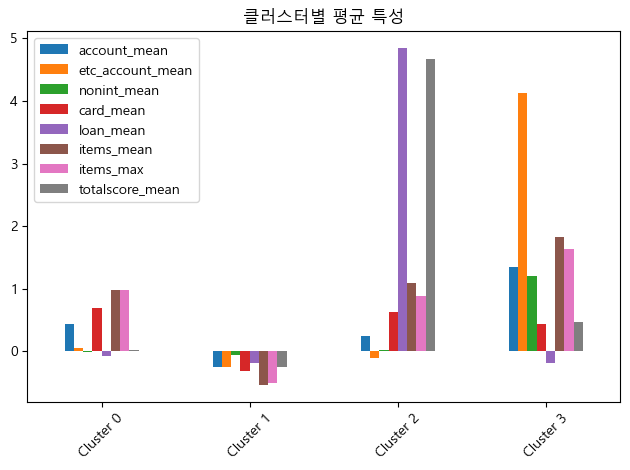

In [9]:
cluster_mean, cluster_means_df = kmeans_clustering(data.drop(['surv', 'surv_periods'], axis = 1))

In [10]:
data_customer.head()

,고객ID,surv,surv_periods,age,account_mean,etc_account_mean,nonint_mean,card_mean,loan_mean,items_mean,items_max,totalscore_mean
0,8364766173,0,36,50,6.841935e+06,0.000000e+00,0.0,322.580645,0.000000,1.032258,2,561.025806
1,9287111747,0,36,60,1.000000e+05,0.000000e+00,0.0,0.000000,0.000000,1.000000,1,30.580645
2,3950901528,0,36,10,0.000000e+00,9.032258e+05,0.0,0.000000,0.000000,1.000000,1,60.516129
3,2641769126,0,17,20,1.176471e+04,0.000000e+00,0.0,0.000000,105882.352941,0.235294,2,54.085294
4,2592393283,0,15,60,0.000000e+00,4.946667e+07,0.0,0.000000,0.000000,1.000000,1,1858.000000


<Figure size 1200x600 with 0 Axes>

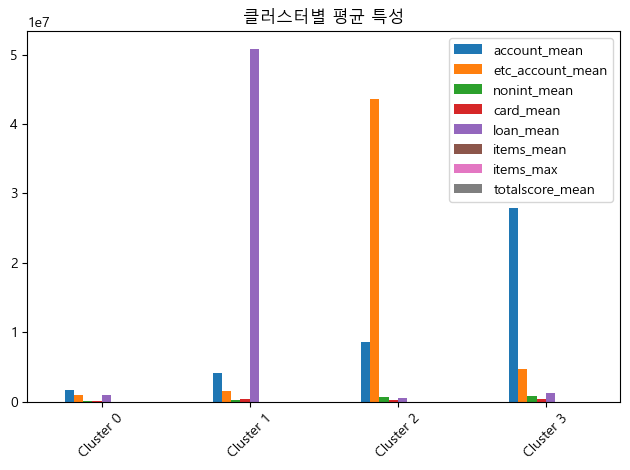

In [11]:
cluster_mean, cluster_means_df = kmeans_clustering(data_customer.drop(['고객ID','surv', 'surv_periods', 'age'], axis = 1))

## 최종 데이터 생성 

In [12]:
cluster = pd.DataFrame(cluster_mean)
cluster = cluster.rename(columns={
    0:'clusters'
})

In [13]:
cluster.value_counts()

clusters
0           1767478
3             80589
2             68227
1             62399
Name: count, dtype: int64

In [14]:
data_customer.shape

(1978693, 12)

In [15]:
tmp = pd.concat([data_customer,cluster], axis = 1)

In [16]:
tmp.tail()

,고객ID,surv,surv_periods,age,account_mean,etc_account_mean,nonint_mean,card_mean,loan_mean,items_mean,items_max,totalscore_mean,clusters
1978688,4569534483,0,36,10,5.161290e+06,0.000000e+00,0.0,0.000000,0.000000e+00,1.000000,1,428.774194,0
1978689,9210230865,0,36,60,1.967742e+05,0.000000e+00,0.0,0.000000,0.000000e+00,0.354839,1,30.236559,0
1978690,5410243231,0,36,20,1.935484e+04,2.093548e+06,0.0,1290.322581,0.000000e+00,1.096774,2,106.963441,0
1978691,3752240572,0,36,30,3.129032e+05,0.000000e+00,0.0,66451.612903,4.574194e+07,3.000000,3,19585.655914,1
1978692,2687211488,0,19,30,5.263158e+03,0.000000e+00,0.0,0.000000,0.000000e+00,0.052632,1,5.157895,0


In [17]:
tmp.to_csv('data/data_customer_cluster_2.csv')

# EDA

In [18]:
# 데이터 각 클러스터별로 분해해

d1 = tmp[tmp['clusters']==0]
d2 = tmp[tmp['clusters']==1]
d3 = tmp[tmp['clusters']==2]
d4 = tmp[tmp['clusters']==3]

In [19]:
# 파이 차트 그리기 함수

def plot_age_distribution(data, data_name):
    age_counts = data['age'].value_counts()
    plt.figure(figsize=(10, 6))
    plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%')
    plt.title(f'{data_name}의 나이 분포')
    plt.show()


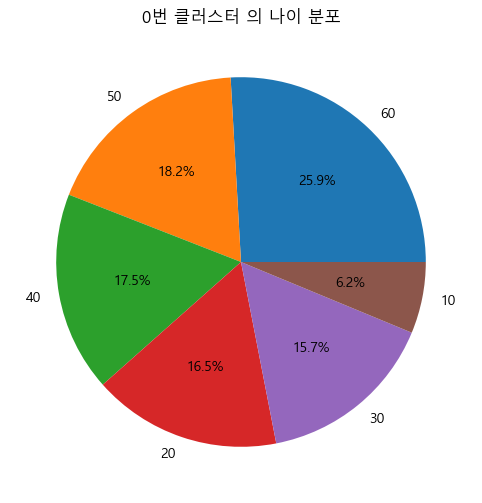

In [20]:
plot_age_distribution(d1, '0번 클러스터 ')

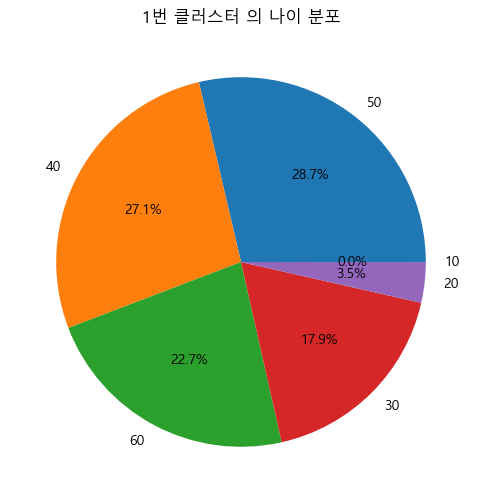

In [21]:
plot_age_distribution(d2, '1번 클러스터 ')

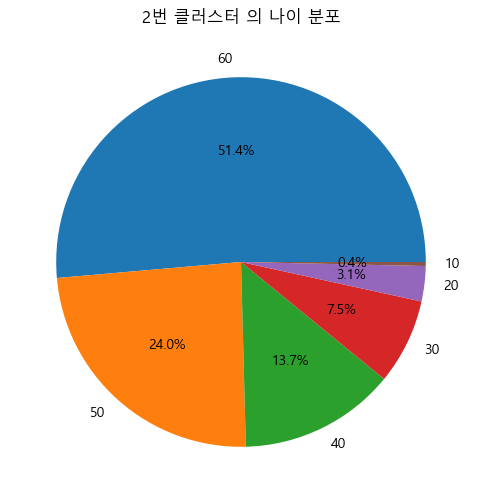

In [22]:
plot_age_distribution(d3, '2번 클러스터 ')

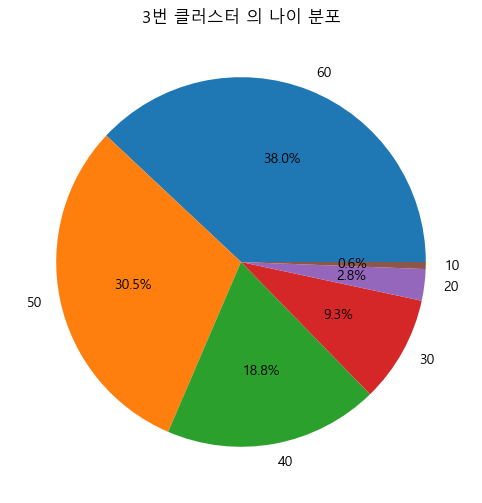

In [23]:
plot_age_distribution(d4, '3번 클러스터 ')

In [24]:
d2[d2['age'] == 10]

,고객ID,surv,surv_periods,age,account_mean,etc_account_mean,nonint_mean,card_mean,loan_mean,items_mean,items_max,totalscore_mean,clusters
595717,2099355682,0,3,10,666666.666667,0.0,0.0,0.0,3.333333e+07,1.666667,2,4570.583333,1
782773,2144045324,0,4,10,0.000000,0.0,0.0,0.0,3.175000e+07,1.000000,1,5488.708333,1


# Cluster By 3


<Figure size 1200x600 with 0 Axes>

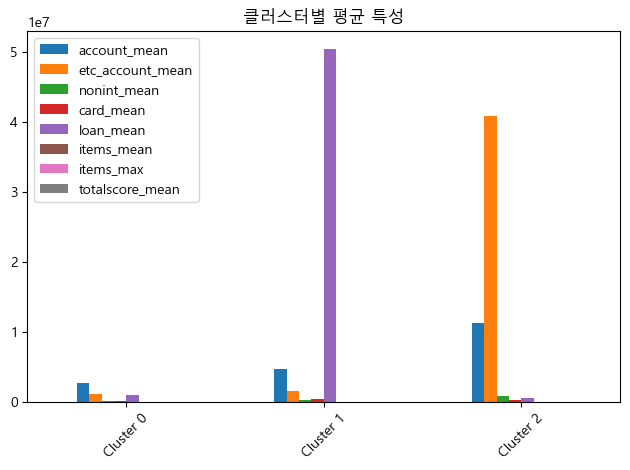

In [25]:
cluster_mean_3, cluster_means_df_3 = kmeans_clustering(data_customer.drop(['고객ID','surv', 'surv_periods', 'age'], axis = 1), n_clusters=3)

In [26]:
tmp_3 = pd.concat([data_customer, pd.DataFrame(cluster_mean_3).rename(columns={0:'cluster'})], axis = 1)

In [27]:
tmp_3['cluster'].value_counts()

cluster
0    1836382
2      78687
1      63624
Name: count, dtype: int64

In [28]:
tmp_3[tmp_3['cluster'] == 2]['etc_account_mean']

4          4.946667e+07
8          5.213548e+07
22         1.582903e+07
34         4.985714e+07
36         2.470968e+07
               ...     
1978618    5.100000e+07
1978619    5.008387e+07
1978656    4.427778e+07
1978661    4.800000e+07
1978677    7.147419e+07
Name: etc_account_mean, Length: 78687, dtype: float64

In [29]:
tmp_3.columns

Index(['고객ID', 'surv', 'surv_periods', 'age', 'account_mean',
       'etc_account_mean', 'nonint_mean', 'card_mean', 'loan_mean',
       'items_mean', 'items_max', 'totalscore_mean', 'cluster'],
      dtype='object')

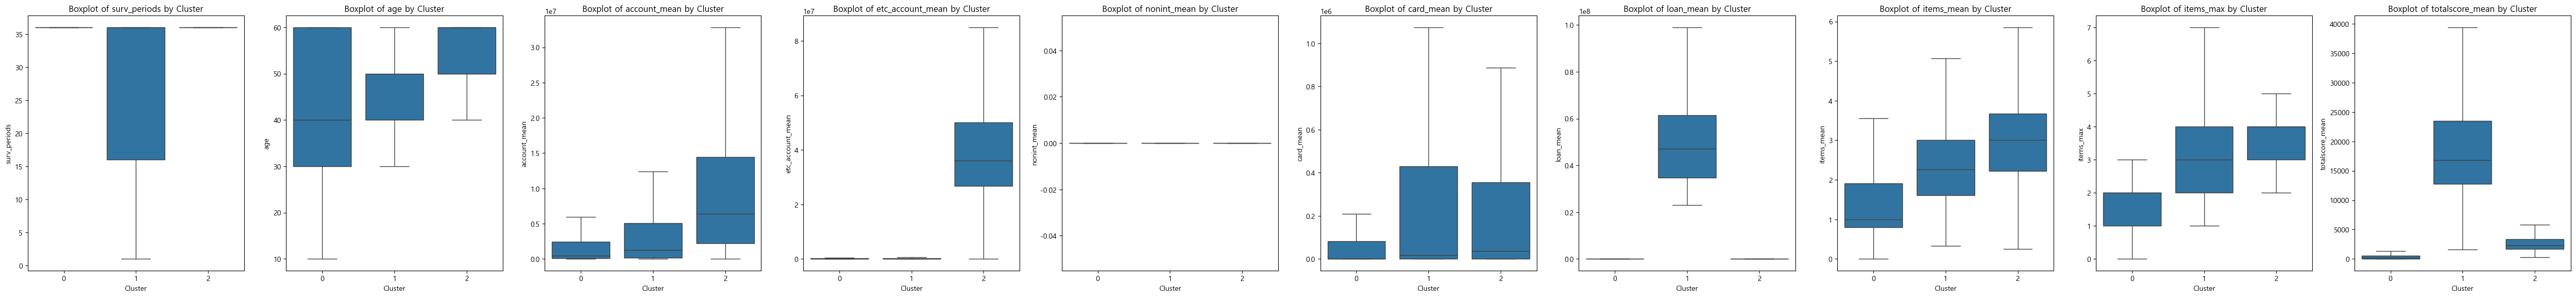

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplot_by_cluster(data, features):
    num_features = len(features)
    fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(5 * num_features, 6))

    if num_features == 1:
        axes = [axes]  # 리스트로 변환하여 일관된 인덱싱 유지

    for ax, column in zip(axes, features):
        sns.boxplot(x='cluster', y=column, data=data, ax=ax, showfliers=False)
        ax.set_title(f'Boxplot of {column} by Cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel(column)

    plt.tight_layout()
    plt.show()

# 사용 예시 (특정한 feature 리스트 적용)
features = ['surv_periods', 'age', 'account_mean',
       'etc_account_mean', 'nonint_mean', 'card_mean', 'loan_mean',
       'items_mean', 'items_max', 'totalscore_mean']
plot_boxplot_by_cluster(tmp_3, features)


# 시각화

c:\Users\campus3S031\Desktop\iMBank\iM_DiGital_Banker_academy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


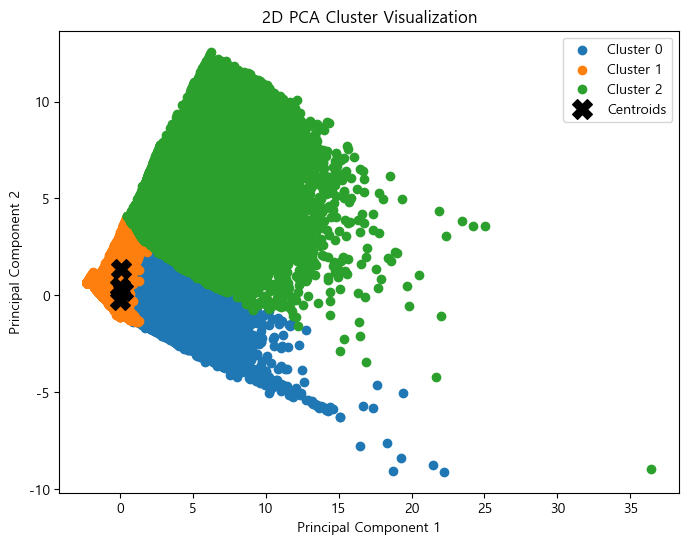

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

pca_data = data.drop(columns=['surv_periods'])

# 클러스터링
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_data)
    
# 클러스터별 특성 분석
cluster_means = []
for i in range(n_clusters):
    cluster_data = data[clusters == i]
    cluster_means.append(cluster_data.mean())

# 2D 시각화 (PCA 변환)
pca = PCA(n_components=2)
reduced_2d = pca.fit_transform(pca_data)

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(reduced_2d[clusters == i, 0], reduced_2d[clusters == i, 1], label=f'Cluster {i}')
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.title("2D PCA Cluster Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

## 반대로 해 보기 

In [32]:
cluster_means_df

,account_mean,etc_account_mean,nonint_mean,card_mean,loan_mean,items_mean,items_max,totalscore_mean
Cluster 0,1.687507e+06,1.041305e+06,98690.964407,117921.127421,9.760006e+05,1.278888,1.837659,589.400889
Cluster 1,4.195420e+06,1.479987e+06,251208.292162,353356.812860,5.081969e+07,2.364677,2.787753,18782.011543
Cluster 2,8.542517e+06,4.363733e+07,746005.247680,255691.288158,5.916345e+05,2.930383,3.398156,2730.512185
Cluster 3,2.790939e+07,4.667836e+06,850921.496421,392218.784075,1.252579e+06,2.100344,2.598717,3037.293068


In [33]:
cluster_mean

array([0, 0, 0, ..., 0, 1, 0])

# Analyze based on tmp points

In [34]:
def quartile_segments(df):
    # 사분위수 계산
    scores = df['totalscore_mean']
    q1, q2, q3 = np.percentile(df['totalscore_mean'], [25, 50, 75])
    
    # 그룹 분류
    segments = pd.Series(index=df.index, dtype='object')
    segments[scores <= q1] = 'Q1'  # 하위 25%
    segments[(scores > q1) & (scores <= q2)] = 'Q2'  # 25~50%
    segments[(scores > q2) & (scores <= q3)] = 'Q3'  # 50~75%
    segments[scores > q3] = 'Q4'  # 상위 25%
    
    # 각 그룹별 데이터 저장
    q1_group = df[segments == 'Q1']
    q2_group = df[segments == 'Q2']
    q3_group = df[segments == 'Q3']
    q4_group = df[segments == 'Q4']

    return q1_group, q2_group, q3_group, q4_group

In [35]:
q1, q2, q3, q4 = quartile_segments(data)

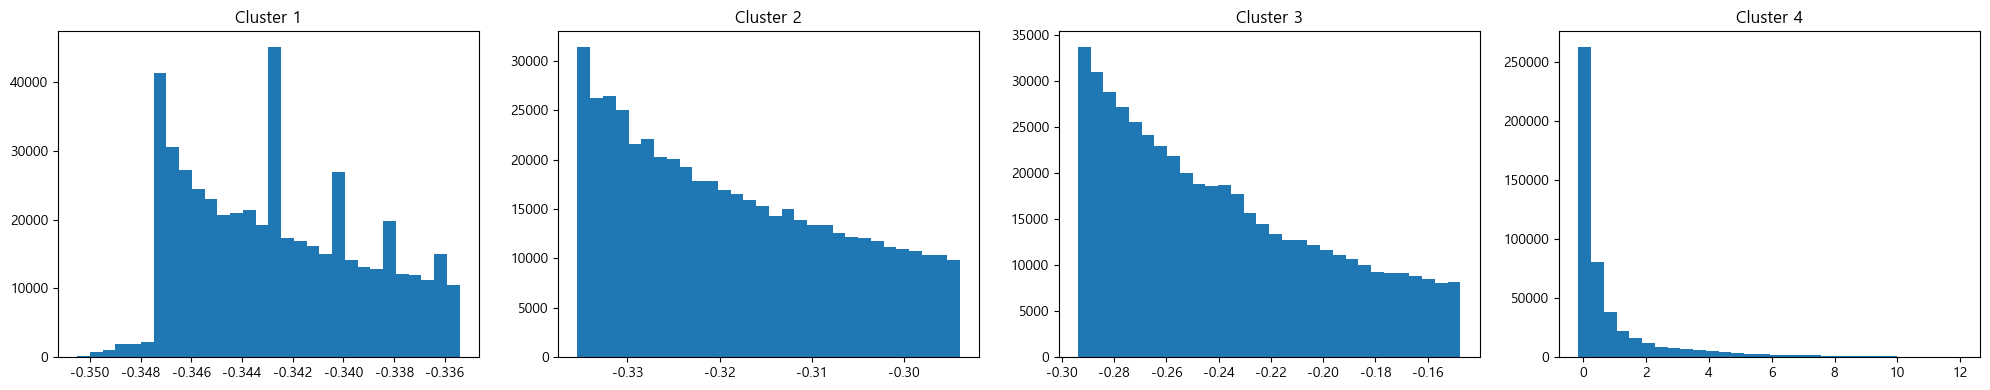

In [36]:
fig, axes = plt.subplots(1, 4, figsize = (20,4))

for nums, i in enumerate([q1,q2,q3,q4]):
    axes[nums].hist(i['totalscore_mean'], bins=30)
    axes[nums].set_title(f'Cluster {nums +1}')
    
plt.tight_layout()

# Kmeans tmp